In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import hdf5plugin
import h5py as h5
import numba

from boost_corr.twotime import TwotimeCorrelator

from skbeam.core.correlation import two_time_corr

In [2]:
def ttc_to_g2(ttc, time=None):
    """Calculate g2 function from TTC

    Args:
        cor (np.ndarray): sqaure correlation matrix (TTC)
        time (np.ndarray, optional): 1D vector of lag times. Defaults to None.
            If None, np.arange will be used for evenly spaced time bins.
    """

    ntimes = ttc.shape[0]
    if time is None:
        time = np.arange(ntimes) + 1

    # initialize output array
    tau = np.ones(ntimes)
    g2 = np.ones(ntimes)
    g2_err = np.ones(ntimes)
    tau = time
    for i in range(1, ntimes):
        dia = np.diag(ttc, k=i)
        ind = np.where(np.isfinite(dia))
        if len(dia[ind]):
            g2[i-1] = np.mean(dia[ind])
            g2_err[i-1] = np.std(dia[ind])
    g2_err *= np.sqrt(1.0 / (ntimes))
    return tau, g2[:-1], g2_err[:-1]

In [3]:
with h5.File('cmake-build-release/ttc.hdf5') as cpp_file:
    ttc = cpp_file['ttc'][()]
    dt = cpp_file['dt'][()]
    time = np.linspace(dt, ttc.shape[0]*dt, ttc.shape[0])
    cpp_img = cpp_file['avg_img'][()]
    # cpp_roi = cpp_file['waxs/roi_data'][()]


In [4]:
time

array([5.0000e-04, 1.0000e-03, 1.5000e-03, ..., 2.5005e+00, 2.5010e+00,
       2.5015e+00])

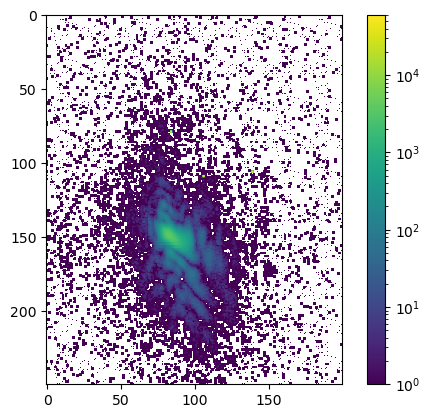

In [5]:
plt.imshow(cpp_img, norm=LogNorm())
plt.colorbar()

In [6]:
with h5.File('data/scan_000186_eiger500k.hdf5') as original_file:
    original_image = original_file['/entry/instrument/Eiger/data'][:5000, 100:350, 600:800]
    original_image[original_image >= 2e4] = 0
    sqnc = original_file['/entry/instrument/Eiger/sequence_number'][:5000]

In [7]:
for i in range(10):
    num = (original_image[sqnc[i]] * original_image[sqnc[i+1]]).mean()
    denom = original_image[sqnc[i]].mean() * original_image[sqnc[i+1]].mean()
    print(num / denom, num, denom)

213.9565503620803 0.00052 2.4304e-06
227.16946842344387 0.0004 1.7608000000000001e-06
166.16553252096853 0.00042 2.5275999999999997e-06
125.44998363695865 0.00046 3.6668e-06
135.18495760108146 0.00044 3.2548e-06
126.58227848101266 0.00024 1.896e-06
220.30651340996172 0.00046 2.0879999999999997e-06
189.465706707086 0.0006 3.1668e-06
132.27513227513228 0.00026 1.9656e-06
250.7716049382716 0.00052 2.0736e-06


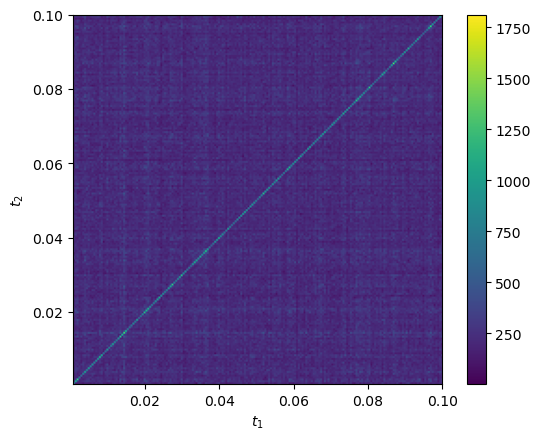

In [8]:
fig, ax = plt.subplots()
ttc_plot = ax.imshow(
    ttc,
    # norm=LogNorm(),
    origin='lower',
    cmap='viridis',
    extent = [time.min(), time.max(), time.min(), time.max()],
)
plt.xlim(dt, 0.1)
plt.ylim(dt, 0.1)
# ax_x = ax.secondary_yaxis('right')
# ax_x.set_yticks(np.arange(0,ttc_submat.shape[0]))
# ax_y = ax.secondary_xaxis('top')
# ax_y.set_xticks(np.arange(0,ttc_submat.shape[0]))
ax.set_xlabel('$t_1$')
ax.set_ylabel('$t_2$')
fig.colorbar(ttc_plot)
plt.show()

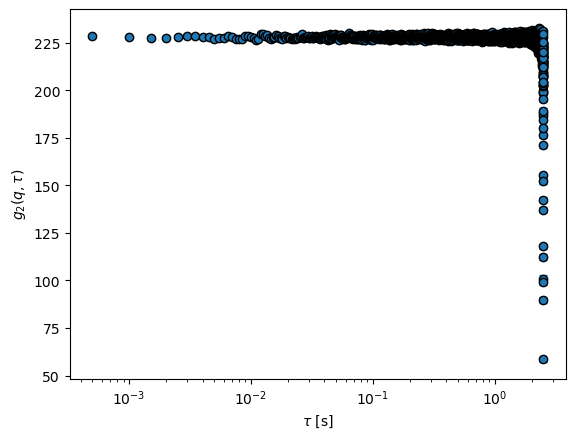

In [9]:
_, g2, g2_err = ttc_to_g2(ttc, 500)
plt.errorbar(time[:-1], g2, yerr=g2_err, marker='o', markeredgecolor='k', capsize=3, linestyle='')
plt.xscale('log')
# plt.xlim(time[0]-0.01,0.1)
plt.ylabel(r'$g_2(q, \tau)$')
plt.xlabel(r'$\tau$ [s]')
plt.show()

In [10]:
data = original_image.reshape(original_image.shape[0], original_image.shape[1]*original_image.shape[2])

In [38]:
@numba.njit(parallel=True)
def calcC2(data):
    ttc = np.zeros((data.shape[0], data.shape[0]), dtype=np.float32)
    for i in numba.prange(data.shape[1]):
        pix = data[:, i]
        ttc += np.outer(pix, pix)
    # ttc /= data.shape[0]
    return ttc

In [41]:
_ttc = calcC2(data[:5])
np.fill_diagonal(_ttc, np.mean(_ttc))

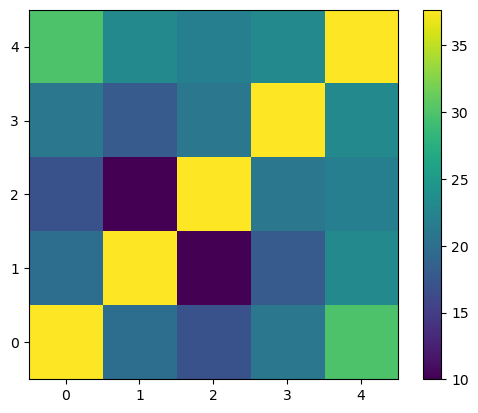

In [43]:
plt.imshow(_ttc, origin='lower')
plt.colorbar()